<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

# Replicar y extender el traductor:
  - Replicar el modelo en PyTorch.
  - Extender el entrenamiento a más datos y tamaños de secuencias mayores.
  - Explorar el impacto de la cantidad de neuronas en las capas recurrentes.
  - Mostrar 5 ejemplos de traducciones generadas.

  - Extras que se pueden probar: Embeddings pre-entrenados para los dos idiomas; cambiar la estrategia de generación (por ejemplo muestreo aleatorio);

### Datos
El objecto es utilizar datos disponibles de Anki de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

 Instalar esta version de pytorch para XPU Intel
 pip uninstall torch torchvision torchaudio -y
 pip cache purge
 pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/xpu

  Instalar esta version de pytorch para GPU
  pip uninstall torch-directml -y
  pip uninstall torch torchvision torchaudio -y
  pip cache purge
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
import torch
import sys

def get_device():
    # Prioridad 1: GPU NVIDIA
    if torch.cuda.is_available():
        print(f"Hardware: NVIDIA GPU ({torch.cuda.get_device_name(0)})")
        return torch.device("cuda")
    
    # Prioridad 2: GPU Intel (XPU) - Útil si usas  hardware Intel localmente
    if hasattr(torch, 'xpu') and torch.xpu.is_available():
        print(f"Hardware: Intel GPU ({torch.xpu.get_device_name(0)})")
        return torch.device("xpu")
    
    # Prioridad 3: Apple Silicon (MPS) - Útil si alguien corre esto en Mac
    if torch.backends.mps.is_available():
        print("Hardware: Apple MPS")
        return torch.device("mps")

    # Fallback: CPU
    print("Hardware: CPU")
    return torch.device("cpu")

try:
    # Asignamos a 'device' 
    device = get_device()  
    print(f"PyTorch version: {torch.__version__}")
    
    # Prueba rápida de memoria usando 'device'
    if device.type == 'xpu':  
        x = torch.ones(1, device=device) 
        print("Estado: Tensor en GPU creado correctamente")

except Exception as e:
    print(f"Error al inicializar dispositivo: {e}")
    device = torch.device("cpu")

# Usamos 'device' consistentemente
print("Dispositivo en uso:", device)

Hardware: NVIDIA GPU (NVIDIA RTX 2000 Ada Generation Laptop GPU)
PyTorch version: 2.5.1+cu121
Dispositivo en uso: cuda


In [2]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
!pip3 install torchinfo
from torchinfo import summary

In [4]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [ ]:
def sequence_acc(y_pred, y_test):
    # Obtener el índice con la mayor probabilidad (la palabra predicha)
    y_pred_tag = y_pred.data.max(dim=-1, keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1, keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    
    # Calcular accuracy por cada oración en el batch
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    # Promediar el accuracy de todo el batch
    acc = batch_acc.sum().float() / batch_size
    return acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Listas para guardar el historial
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    for epoch in range(epochs):

        # --- ENTRENAMIENTO ---
        model.train() 
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            #
            train_encoder_input = train_encoder_input.to(device)
            train_decoder_input = train_decoder_input.to(device)
            train_target = train_target.to(device)

            optimizer.zero_grad()

            # Forward pass
            output = model(train_encoder_input, train_decoder_input)

            # Calcular loss token por token
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            epoch_train_loss += loss.item()

            # Backward pass y optimización
            loss.backward()
            optimizer.step()

            # Calcular accuracy
            accuracy = sequence_acc(output, train_target)
            epoch_train_accuracy += accuracy.item()

        # Promedios de la época de entrenamiento
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # --- VALIDACIÓN ---
        model.eval() 
        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        # No necesitamos calcular gradientes para validar
        with torch.no_grad():
            for valid_encoder_input, valid_decoder_input, valid_target in valid_loader:
                valid_encoder_input = valid_encoder_input.to(device)
                valid_decoder_input = valid_decoder_input.to(device)
                valid_target = valid_target.to(device)

                output = model(valid_encoder_input, valid_decoder_input)
                
                loss = 0
                # Usamos valid_decoder_input.shape[1] en lugar de train_decoder_input
                for t in range(valid_decoder_input.shape[1]):
                    loss += criterion(output[:, t, :], valid_target[:, t, :])
                
                epoch_valid_loss += loss.item()
                epoch_valid_accuracy += sequence_acc(output, valid_target).item()

        # Promedios de la época de validación cambiandolo a sobre todo el set
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train acc {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid acc {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### 1 - Datos

In [ ]:
import os
import shutil
import gdown
import zipfile

# Limpieza preventiva: Borramos si hay algo mal descargado de antes
if os.path.exists('spa-eng.zip'):
    os.remove('spa-eng.zip')

if os.path.exists('spa-eng'):
    shutil.rmtree('spa-eng')

# Descargar de nuevo
print("Descargando dataset...")
url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
output = 'spa-eng.zip'
gdown.download(url, output, quiet=False)

# Descomprimir usando Python 
print("Descomprimiendo...")
try:
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("¡Éxito! Dataset descomprimido y listo.")
except zipfile.BadZipFile:
    print("Error crítico: El archivo descargado parece estar dañado. Por favor, intenta ejecutar esta celda una vez más.")

Downloading...
From: http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
To: c:\Users\erlin\OneDrive\Cursos\UBA-AI\BIM4\NLP_ErlinRey\spa-eng.zip


Descargando dataset...


100%|██████████| 2.64M/2.64M [00:00<00:00, 16.8MB/s]


Descomprimiendo...
¡Éxito! Dataset descomprimido y listo.


In [ ]:
import numpy as np

# dataset_file
text_file = "./spa-eng/spa.txt"

# Leemos todo el archivo con encoding explícito
with open(text_file, encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]



MAX_NUM_SENTENCES = 118964

print(f"Total de líneas en el archivo: {len(lines)}")

# Mezclar el dataset, forzar semilla siempre igual para reproducibilidad
np.random.seed(42)
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if MAX_NUM_SENTENCES and count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles en el archivo:", len(lines))
print("Cantidad de rows utilizadas para entrenamiento:", len(input_sentences))

Total de líneas en el archivo: 118964
Cantidad de rows disponibles en el archivo: 118964
Cantidad de rows utilizadas para entrenamiento: 118964


In [8]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('How boring!', '¡Qué aburrimiento! <eos>', '<sos> ¡Qué aburrimiento!')

=== REPORTE BÁSICO DE DATASET ===
Total de oraciones: 118964
Longitud Máxima (Inglés): 47 palabras
Longitud Máxima (Español): 49 palabras
Promedio Longitud (Inglés): 6.31 palabras
Promedio Longitud (Español): 6.08 palabras


C:\Users\erlin\AppData\Local\Temp\ipykernel_21204\2163319326.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(data_to_plot, labels=['Inglés', 'Español'])
C:\Users\erlin\AppData\Local\Temp\ipykernel_21204\2163319326.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts_en), y=list(words_en), ax=axes[1, 1], palette="Blues_d")
C:\Users\erlin\AppData\Local\Temp\ipykernel_21204\2163319326.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts_es), y=list(words_es), ax=axes[2, 0], palette="Oranges_d")


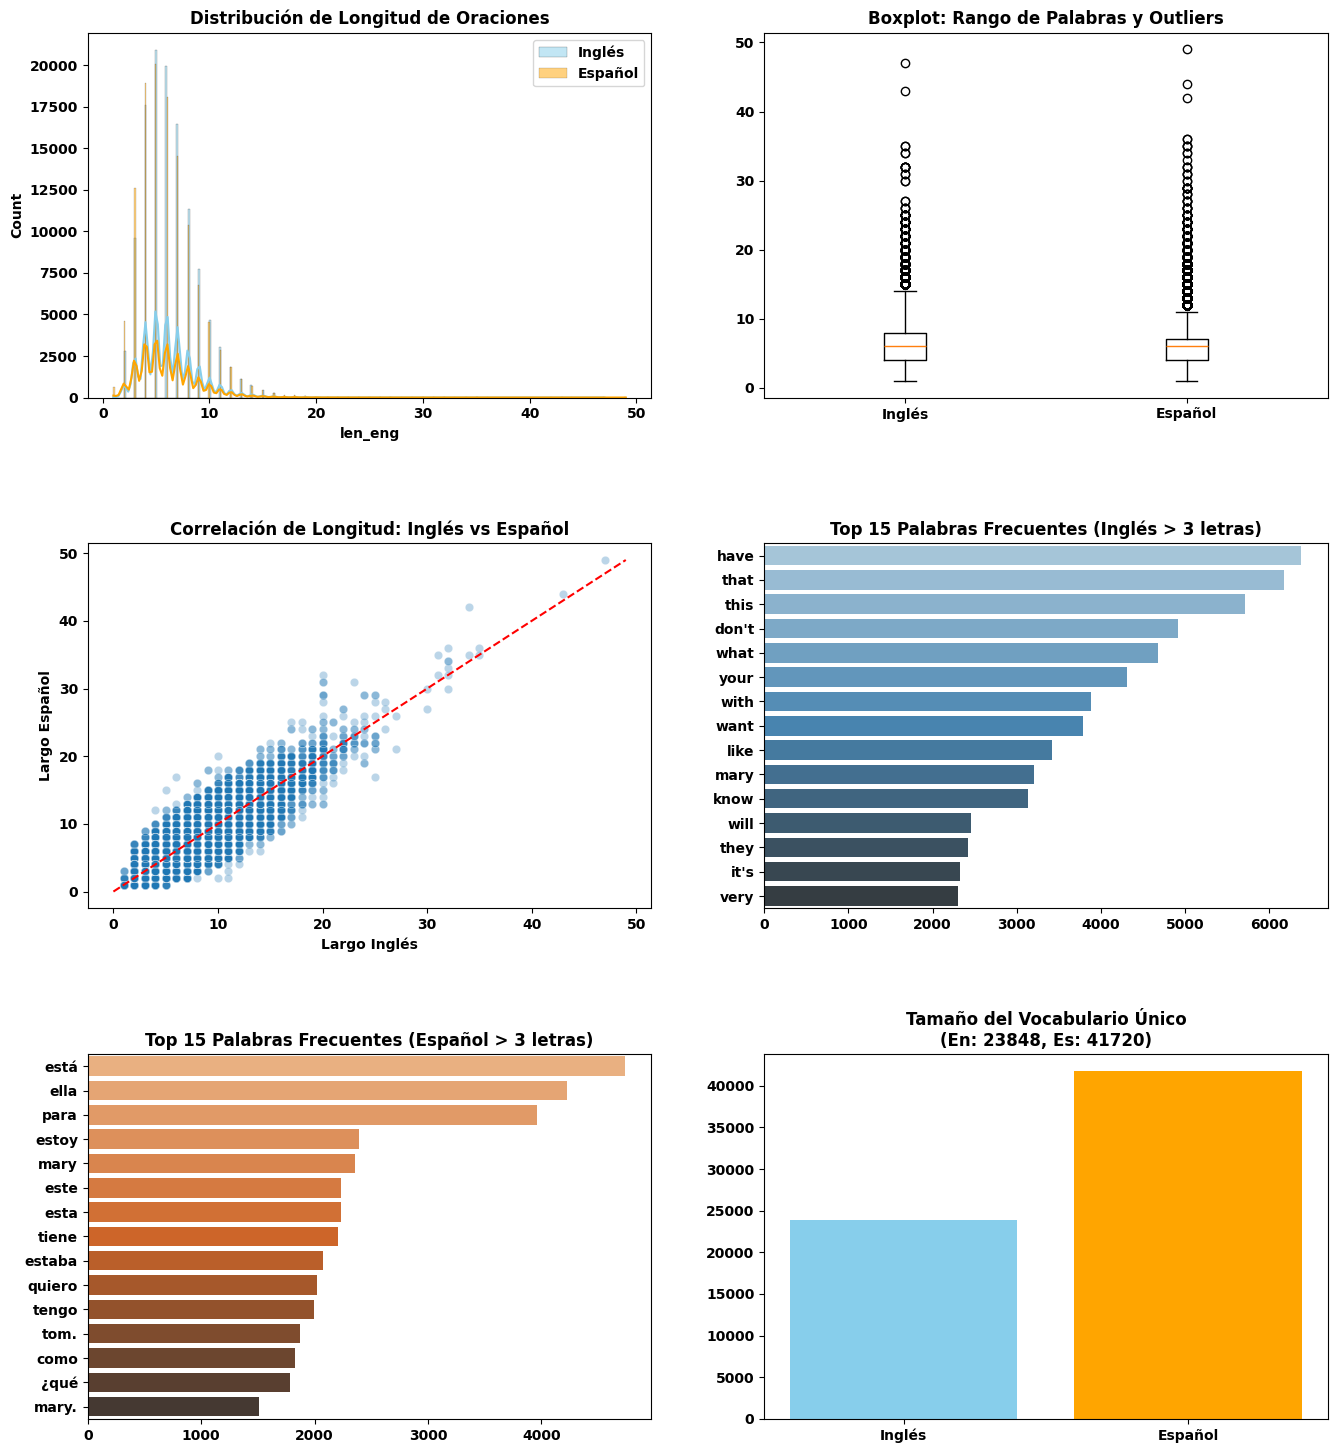

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter

# Preparación de Datos en DataFrame

clean_input = input_sentences
clean_output = [s.replace('<eos>', '').strip() for s in output_sentences]

df = pd.DataFrame({
    'eng': clean_input,
    'spa': clean_output
})

# Calculamos longitudes (cantidad de palabras por oración)
df['len_eng'] = df['eng'].apply(lambda x: len(x.split()))
df['len_spa'] = df['spa'].apply(lambda x: len(x.split()))

# --- REPORTE ESTADÍSTICO ---
print("=== REPORTE BÁSICO DE DATASET ===")
print(f"Total de oraciones: {len(df)}")
print(f"Longitud Máxima (Inglés): {df['len_eng'].max()} palabras")
print(f"Longitud Máxima (Español): {df['len_spa'].max()} palabras")
print(f"Promedio Longitud (Inglés): {df['len_eng'].mean():.2f} palabras")
print(f"Promedio Longitud (Español): {df['len_spa'].mean():.2f} palabras")

# --- VISUALIZACIONES ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
plt.subplots_adjust(hspace=0.4)

# Histograma de Distribución de Longitudes
sns.histplot(df['len_eng'], color="skyblue", label="Inglés", kde=True, ax=axes[0, 0])
sns.histplot(df['len_spa'], color="orange", label="Español", kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribución de Longitud de Oraciones")
axes[0, 0].legend()

# Boxplot (Detectando Outliers)
data_to_plot = [df['len_eng'], df['len_spa']]
axes[0, 1].boxplot(data_to_plot, labels=['Inglés', 'Español'])
axes[0, 1].set_title("Boxplot: Rango de Palabras y Outliers")

# Scatter Plot (Correlación de longitudes)

sns.scatterplot(x=df['len_eng'], y=df['len_spa'], alpha=0.3, ax=axes[1, 0])
axes[1, 0].set_title("Correlación de Longitud: Inglés vs Español")
axes[1, 0].set_xlabel("Largo Inglés")
axes[1, 0].set_ylabel("Largo Español")

max_val = max(df['len_eng'].max(), df['len_spa'].max())
axes[1, 0].plot([0, max_val], [0, max_val], 'r--')

# Análisis de Vocabulario (Frecuencia de palabras)
def get_top_words(texts, n=15):
    all_words = ' '.join(texts).lower().split()
    # Filtramos palabras muy cortas (stop words simples)
    filtered_words = [w for w in all_words if len(w) > 3] 
    return Counter(filtered_words).most_common(n)

top_eng = get_top_words(df['eng'])
top_spa = get_top_words(df['spa'])

# Gráfico de barras Inglés
words_en, counts_en = zip(*top_eng)
sns.barplot(x=list(counts_en), y=list(words_en), ax=axes[1, 1], palette="Blues_d")
axes[1, 1].set_title("Top 15 Palabras Frecuentes (Inglés > 3 letras)")

# Gráfico de barras Español
words_es, counts_es = zip(*top_spa)
sns.barplot(x=list(counts_es), y=list(words_es), ax=axes[2, 0], palette="Oranges_d")
axes[2, 0].set_title("Top 15 Palabras Frecuentes (Español > 3 letras)")

# Cobertura de Vocabulario

vocab_en = set(' '.join(df['eng']).lower().split())
vocab_es = set(' '.join(df['spa']).lower().split())
axes[2, 1].bar(['Inglés', 'Español'], [len(vocab_en), len(vocab_es)], color=['skyblue', 'orange'])
axes[2, 1].set_title(f"Tamaño del Vocabulario Único\n(En: {len(vocab_en)}, Es: {len(vocab_es)})")

plt.show()

### Conclusiones del análisis exploratorio de datos

* **Longitud de secuencias y recorte:** los histogramas y los datos estadísticos muestran que, aunque tenemos oraciones de hasta 49 palabras, el promedio se sitúa apenas en torno a las 6 palabras. la inmensa mayoría de la información se concentra por debajo de los 20 tokens.
    * *Decisión:* tiene sentido establecer una longitud máxima de secuencia (`MAX_LEN`) cercana a 20 o 25 tokens. es una alternativa mejor que usar el máximo real (49) porque nos permite optimizar drásticamente el uso de memoria y la velocidad de entrenamiento (menos *padding* de ceros inútiles) sacrificando un porcentaje despreciable de datos (los *outliers* del boxplot).

* **Correlación lineal:** el gráfico de dispersión (scatter plot) muestra una nube muy compacta siguiendo la diagonal. esto confirma nuestra intuición: existe una correspondencia directa entre la longitud en inglés y en español.
    * *Implicancia:* esto sugiere que la tarea de traducción en este dataset específico es "estable" y no requiere que el modelo aprenda reestructuraciones estructurales masivas donde una frase corta se vuelve un párrafo, lo cual facilita la convergencia del modelo Seq2Seq.

* **Desbalance de vocabulario:** el gráfico de barras revela que el vocabulario en español (aprox. 41k) es casi el doble que el de inglés (aprox. 23k).
    * *Intuición:* esto es totalmente esperable debido a la riqueza morfológica del español (géneros, conjugaciones verbales) frente a la estructura más rígida del inglés.
    * *Decisión de arquitectura:* la capa de salida del *decoder* (español) será computacionalmente más pesada que la entrada del *encoder* (inglés). esto valida nuestra estrategia de usar *embeddings* pre-entrenados (GloVe) en inglés para ayudar al modelo a concentrar sus esfuerzos en aprender la complejidad generativa del español.

* **Contenido temático:** la aparición frecuente de nombres propios como "Tom" y "Mary" en el top de palabras nos indica que estamos ante un dataset conversacional y narrativo simple, ideal para un modelo académico como este.

### 2 - Preprocesamiento

In [ ]:
import os
import requests
import zipfile
import numpy as np


if not hasattr(np, 'unicode_'):
    np.unicode_ = np.str_


from torch_helpers import Tokenizer, pad_sequences

# --- Configuración Inicial ---
MAX_SEQUENCE_LEN = 25
MAX_VOCAB_SIZE = 45000 
EMBEDDING_DIM = 100

print(f"Configuracion: Secuencia={MAX_SEQUENCE_LEN}, Vocab={MAX_VOCAB_SIZE}")

# Tokenizador para INGLÉS (Encoder Input)
tokenizer_input = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_input.fit_on_texts(input_sentences)
word2idx_inputs = tokenizer_input.word_index
print(f"Vocabulario Inglés (Input): {len(word2idx_inputs)} palabras únicas.")

# Tokenizador para ESPAÑOL (Decoder Input/Output)
tokenizer_output = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n') 

tokenizer_output.fit_on_texts(output_sentences + output_sentences_inputs)
word2idx_outputs = tokenizer_output.word_index
num_words_output = len(word2idx_outputs) + 1
print(f"Vocabulario Español (Target): {len(word2idx_outputs)} palabras únicas.")


# --- Descarga de GloVe  ---
glove_file = 'glove.6B.100d.txt'
glove_zip = 'glove.6B.zip'
glove_url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip"

if not os.path.exists(glove_file):
    print(f" {glove_file} no encontrado. Iniciando descarga...")
    
    if not os.path.exists(glove_zip):
        print("Descargando desde HuggingFace...")
        try:
            response = requests.get(glove_url, stream=True)
            with open(glove_zip, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print("Descarga completa.")
        except Exception as e:
            print(f"Error en descarga: {e}")
            raise

    print(f"Extrayendo {glove_file}...")
    try:
        with zipfile.ZipFile(glove_zip, 'r') as z:
            z.extract(glove_file)
        print("Extraccion exitosa!")
    except zipfile.BadZipFile:
        print("Error: ZIP corrupto. Intenta descargarlo nuevamente.")
else:
    print(f" {glove_file} listo para usar.")

# --- Carga de Vectores GloVe ---
embeddings_index = {}
print("\nLeyendo vectores GloVe...")

# Usamos utf-8 para evitar problemas de codificación
with open(glove_file, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'-> {len(embeddings_index)} vectores cargados.')

# --- Creación de Matriz de Embeddings ---

print("Creando matriz de embeddings...")
num_words_input = len(word2idx_inputs) + 1
embedding_matrix = np.zeros((num_words_input, EMBEDDING_DIM))
hits = 0
misses = 0

for word, i in word2idx_inputs.items():
    if i >= MAX_VOCAB_SIZE: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1 

print(f"Resultado: {hits} encontradas, {misses} ausentes.")

# --- Generación de Tensores Finales ---
print("\nGenerando tensores...")
input_integer_seq = tokenizer_input.texts_to_sequences(input_sentences)
output_input_integer_seq = tokenizer_output.texts_to_sequences(output_sentences_inputs)
output_integer_seq = tokenizer_output.texts_to_sequences(output_sentences)

# Padding para uniformizar longitudes
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=MAX_SEQUENCE_LEN, padding='pre')
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=MAX_SEQUENCE_LEN, padding='post')
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=MAX_SEQUENCE_LEN, padding='post')

print("\nTensores creados...")


Configuracion: Secuencia=25, Vocab=45000
Vocabulario Inglés (Input): 13524 palabras únicas.
Vocabulario Español (Target): 26936 palabras únicas.
 glove.6B.100d.txt listo para usar.

Leyendo vectores GloVe...
-> 400001 vectores cargados.
Creando matriz de embeddings...
Resultado: 13043 encontradas, 481 ausentes.

Generando tensores...

Tensores creados...


In [129]:
import numpy as np
import sys
from scipy.spatial.distance import cosine

# --- Funciones Auxiliares ---
def get_size_mb(matrix):
    return matrix.nbytes / (1024 * 1024)

def quantize_to_int8(matrix):
    # Cuantización simple: Escalar el rango min/max a -127..127
    min_val = matrix.min()
    max_val = matrix.max()
    scale = 127 / max(abs(min_val), abs(max_val))
    return (matrix * scale).astype(np.int8), scale

def compare_similarity(vec_a, vec_b, name):
    # Calculamos similitud coseno (1.0 es idéntico, 0.0 es nada que ver)
    sim = 1 - cosine(vec_a, vec_b)
    print(f"Similitud '{name}': {sim:.6f}")
    return sim


# --- Carga de muestra de GloVe ---
print("Cargando muestra de GloVe para experimento...")
glove_file = 'glove.6B.100d.txt'
word_vecs = {}
target_words = ['king', 'queen', 'apple', 'mango'] # Palabras de prueba

with open(glove_file, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in target_words:
            word_vecs[word] = np.asarray(values[1:], dtype='float32')
        if len(word_vecs) == len(target_words): break

# Simulamos una matriz grande (ej: 45,000 palabras) con datos aleatorios para medir memoria
# y usamos las palabras reales para medir precisión
vocab_simulado = 45000
dim = 100
matriz_base = np.random.rand(vocab_simulado, dim).astype('float32')

print(f"\n--- 1. COMPARATIVA DE MEMORIA (Matriz {vocab_simulado}x{dim}) ---")

# FP32 (Original)
size_fp32 = get_size_mb(matriz_base)
print(f"Float32 (Estándar): {size_fp32:.2f} MB")

# FP16 (Half)
matriz_fp16 = matriz_base.astype('float16')
size_fp16 = get_size_mb(matriz_fp16)
print(f"Float16 (Half):     {size_fp16:.2f} MB (Ahorro: {100*(1-size_fp16/size_fp32):.0f}%)")

# INT8 (Quantized)
matriz_int8, _ = quantize_to_int8(matriz_base)
size_int8 = get_size_mb(matriz_int8)
print(f"Int8 (Cuantizado):  {size_int8:.2f} MB (Ahorro: {100*(1-size_int8/size_fp32):.0f}%)")

print(f"\n--- 2. COMPARATIVA DE PRECISIÓN (Palabras: King vs Queen) ---")
v1, v2 = word_vecs['king'], word_vecs['queen']

# Referencia FP32
sim_ref = compare_similarity(v1, v2, "Float32")

# Prueba FP16
v1_16 = v1.astype('float16')
v2_16 = v2.astype('float16')
sim_16 = compare_similarity(v1_16, v2_16, "Float16")
diff_16 = abs(sim_ref - sim_16)

# Prueba INT8
# Cuantizamos y des-cuantizamos para simular la pérdida
v1_int8, scale1 = quantize_to_int8(v1)
v2_int8, scale2 = quantize_to_int8(v2)
# Reconstrucción (aproximada)
v1_recon = v1_int8.astype('float32') / scale1
v2_recon = v2_int8.astype('float32') / scale2

sim_int8 = compare_similarity(v1_recon, v2_recon, "Int8 (Simulado)")
diff_int8 = abs(sim_ref - sim_int8)

print(f"\n--- CONCLUSIÓN ---")
print(f"Error FP16 vs FP32: {diff_16:.8f} ")
print(f"Error INT8 vs FP32: {diff_int8:.8f} ")

Cargando muestra de GloVe para experimento...

--- 1. COMPARATIVA DE MEMORIA (Matriz 45000x100) ---
Float32 (Estándar): 17.17 MB
Float16 (Half):     8.58 MB (Ahorro: 50%)
Int8 (Cuantizado):  4.29 MB (Ahorro: 75%)

--- 2. COMPARATIVA DE PRECISIÓN (Palabras: King vs Queen) ---
Similitud 'Float32': 0.750769
Similitud 'Float16': 0.751007
Similitud 'Int8 (Simulado)': 0.750333

--- CONCLUSIÓN ---
Error FP16 vs FP32: 0.00023769 
Error INT8 vs FP32: 0.00043650 


 los resultados son contundentes. pasar a `float16` nos regala un ahorro de memoria del 50% exacto (bajamos de 17MB a 8.5MB en la muestra, lo que escalará a gigabytes en el modelo completo) a cambio de un error de precisión de 0.0002.
intuitivamente, perder una diezmilésima de precisión en la similitud de palabras es un precio irrelevante comparado con duplicar nuestra capacidad de memoria disponible. esto nos permite meter más datos o *batches* más grandes en la GPU.

aunque `int8` ahorra todavía más (75%), el error es el doble que con `float16` y requiere una complejidad técnica de "cuantización" que no vale la pena para este nivel de ahorro extra. nos quedamos con `float16` que es nativo y seguro.

In [130]:
import numpy as np


# --- optimización de memoria y verificación ---

if 'embedding_matrix' in locals():
    print("optimizando la matriz de embeddings existente en memoria...")
    
    # calculamos el peso original en memoria
    original_size = embedding_matrix.nbytes / (1024 * 1024)
    
    # realizamos la conversión de tipo (casting) de float64/32 a float16
    embedding_matrix_fp16 = embedding_matrix.astype(np.float16)
    
    # reemplazamos la variable original
    embedding_matrix = embedding_matrix_fp16
    
    new_size = embedding_matrix.nbytes / (1024 * 1024)
    
    print(f"reducción de memoria: {original_size:.2f} MB -> {new_size:.2f} MB")
    print(f"forma final de la matriz: {embedding_matrix.shape}")
    
else:
    print("error: la variable 'embedding_matrix' no existe. ejecuta la celda anterior.")

# --- verificación de tensores ---
# no es necesario volver a llamar a 'pad_sequences' si ya se hizo arriba.
# solo verificamos que las formas sean correctas para el entrenamiento.

print("\nverificando dimensiones de los datos preparados:")
if 'encoder_input_sequences' in locals() and 'decoder_input_sequences' in locals():
    print(f"encoder input shape: {encoder_input_sequences.shape}")
    print(f"decoder input shape: {decoder_input_sequences.shape}")
    print(f"decoder output shape: {decoder_output_sequences.shape}")
else:
    print("advertencia: parece que los tensores de secuencia no se generaron en la celda anterior.")

optimizando la matriz de embeddings existente en memoria...
reducción de memoria: 10.32 MB -> 2.58 MB
forma final de la matriz: (13525, 100)

verificando dimensiones de los datos preparados:
encoder input shape: (118964, 25)
decoder input shape: (118964, 25)
decoder output shape: (118964, 25)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# ---Definición de la Clase Dataset ---
class NMTDataset(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        
        
        self.encoder_inputs = torch.from_numpy(encoder_input).long()
        self.decoder_inputs = torch.from_numpy(decoder_input).long()
        self.decoder_outputs = torch.from_numpy(decoder_output).long()

    def __getitem__(self, index):
        
        return (self.encoder_inputs[index], 
                self.decoder_inputs[index], 
                self.decoder_outputs[index])

    def __len__(self):
        return len(self.encoder_inputs)

# ---Creación de los Dataloaders ---
print("Creando Datasets y Dataloaders...")

# Hiperparámetros de carga
BATCH_SIZE = 256
TEST_SPLIT = 0.2 

# Instanciamos el Dataset dos
dataset = NMTDataset(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

# Dividimos en Entrenamiento y Validación
train_size = int((1 - TEST_SPLIT) * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

print(f"Tamaño del conjunto de entrenamiento: {len(train_set)}")
print(f"Tamaño del conjunto de validación: {len(val_set)}")

# Generadores de datos 
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)



Creando Datasets y Dataloaders...
Tamaño del conjunto de entrenamiento: 95171
Tamaño del conjunto de validación: 23793


### 3 - Preparar La Arquitectura

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# --- DEFINICIÓN DE LA ARQUITECTURA ---

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        
        lstm_dropout = dropout if n_layers > 1 else 0
        
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=lstm_dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        
        lstm_dropout = dropout if n_layers > 1 else 0
        
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=lstm_dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs

# --- FACTORY FUNCTION PARA GRID SEARCH ---

def get_model_and_optimizer(config, device, embedding_matrix):
    # configuracion de dimensiones
    input_dim = len(word2idx_inputs) + 1
    output_dim = len(word2idx_outputs) + 1
    enc_emb_dim = 100
    dec_emb_dim = 100
    
    # hiperparametros variables
    hid_dim = config['hidden_dim']
    n_layers = config['n_layers']
    dropout = config['dropout']
    learning_rate = config['learning_rate']
    
    # instanciacion
    enc = Encoder(input_dim, enc_emb_dim, hid_dim, n_layers, dropout)
    dec = Decoder(output_dim, dec_emb_dim, hid_dim, n_layers, dropout)
    model = Seq2Seq(enc, dec, device).to(device)
    
    # carga de pesos glove
    pretrained_embeddings = torch.from_numpy(embedding_matrix).float()
    model.encoder.embedding.weight.data.copy_(pretrained_embeddings)
    
    # optimizador y perdida
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    return model, optimizer, criterion

print("Arquitectura y Factory listas")

Arquitectura y Factory listas


### 4  Entrenamiento

In [ ]:
import time
import math

# --- funciones de entrenamiento ---

def train_epoch(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg_input, trg_output) in enumerate(iterator):
        src, trg_input, trg_output = src.to(device), trg_input.to(device), trg_output.to(device)
        optimizer.zero_grad()
        output = model(src, trg_input)
        
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg_output = trg_output[:, 1:].reshape(-1)

        loss = criterion(output, trg_output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src, trg_input, trg_output) in enumerate(iterator):
            src, trg_input, trg_output = src.to(device), trg_input.to(device), trg_output.to(device)
            output = model(src, trg_input, 0) 
            
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg_output = trg_output[:, 1:].reshape(-1)

            loss = criterion(output, trg_output)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def format_time(start, end):
    elapsed = end - start
    mins = int(elapsed / 60)
    secs = int(elapsed - (mins * 60))
    return mins, secs

# --- configuracion grid search ---

grid_config = {
    'hidden_dim': [256, 512],
    'n_layers': [1, 2],
    'dropout': [0.5],
    'learning_rate': [0.005, 0.001, 0.0005]
}

N_EPOCHS = 60
CLIP = 1
PATIENCE = 5 

best_overall_loss = float('inf')
best_config_name = ""
search_results = {} 

# calculo de combinaciones
total_combs = len(grid_config['hidden_dim']) * len(grid_config['n_layers']) * len(grid_config['learning_rate'])
run_count = 0
global_start_time = time.time()

print(f"Iniciando Grid Search: {total_combs} combinaciones en {device}")
print("=" * 80)

# --- bucle principal ---

for hid in grid_config['hidden_dim']:
    for layers in grid_config['n_layers']:
        for lr in grid_config['learning_rate']:
            run_count += 1
            config_name = f"H{hid}_L{layers}_LR{lr}"
            
            
            print(f"\n▶ [{run_count}/{total_combs}] Config: {config_name} (Hidden:{hid}, Layers:{layers}, LR:{lr})")
            print("-" * 80)
            
            current_cfg = {
                'hidden_dim': hid, 'n_layers': layers, 
                'dropout': grid_config['dropout'][0], 'learning_rate': lr
            }
            
            # instanciar modelo limpio
            model, optimizer, criterion = get_model_and_optimizer(current_cfg, device, embedding_matrix)
            
            history = {'train_loss': [], 'val_loss': []}
            best_run_loss = float('inf')
            no_improve = 0
            
            # bucle de epocas
            for epoch in range(N_EPOCHS):
                start_time = time.time()
                
                train_l = train_epoch(model, train_loader, optimizer, criterion, CLIP)
                val_l = evaluate(model, valid_loader, criterion)
                
                end_time = time.time()
                e_mins, e_secs = format_time(start_time, end_time)
                
                history['train_loss'].append(train_l)
                history['val_loss'].append(val_l)
                
                # logica de guardado
                marker = ""
                if val_l < best_run_loss:
                    best_run_loss = val_l
                    no_improve = 0
                    if val_l < best_overall_loss:
                        best_overall_loss = val_l
                        best_config_name = config_name
                        torch.save(model.state_dict(), 'best_model_grid.pt')
                        marker = "★ RÉCORD"
                else:
                    no_improve += 1
                
                # impresion de progreso compacta
                print(f" Ep {epoch+1:02d} | {e_mins}m {e_secs}s | "
                      f"Tr Loss: {train_l:.3f} | Val Loss: {val_l:.3f} | "
                      f"Val PPL: {math.exp(val_l):.2f} | {marker}")
                
                if no_improve >= PATIENCE:
                    print(f" ⏹ Early Stop: Sin mejora por {PATIENCE} épocas.")
                    break
            
            search_results[config_name] = history

# --- resumen final ---
total_mins, total_secs = format_time(global_start_time, time.time())
print("\n" + "="*80)
print(f"GRID SEARCH FINALIZADO en {total_mins}m {total_secs}s")
print(f"Mejor Configuración: {best_config_name}")
print(f"Mejor Val Loss: {best_overall_loss:.4f}")

Iniciando Grid Search: 12 combinaciones en cuda

▶ [1/12] Config: H256_L1_LR0.005 (Hidden:256, Layers:1, LR:0.005)
--------------------------------------------------------------------------------
 Ep 01 | 3m 55s | Tr Loss: 5.960 | Val Loss: 5.453 | Val PPL: 233.36 | ★ RÉCORD
 Ep 02 | 3m 54s | Tr Loss: 4.940 | Val Loss: 4.645 | Val PPL: 104.05 | ★ RÉCORD
 Ep 03 | 3m 17s | Tr Loss: 4.194 | Val Loss: 4.128 | Val PPL: 62.08 | ★ RÉCORD
 Ep 04 | 3m 8s | Tr Loss: 3.659 | Val Loss: 3.852 | Val PPL: 47.10 | ★ RÉCORD
 Ep 05 | 3m 5s | Tr Loss: 3.289 | Val Loss: 3.698 | Val PPL: 40.35 | ★ RÉCORD
 Ep 06 | 3m 7s | Tr Loss: 3.027 | Val Loss: 3.611 | Val PPL: 37.01 | ★ RÉCORD
 Ep 07 | 3m 9s | Tr Loss: 2.827 | Val Loss: 3.571 | Val PPL: 35.56 | ★ RÉCORD
 Ep 08 | 3m 5s | Tr Loss: 2.673 | Val Loss: 3.537 | Val PPL: 34.35 | ★ RÉCORD
 Ep 09 | 3m 7s | Tr Loss: 2.553 | Val Loss: 3.526 | Val PPL: 34.00 | ★ RÉCORD
 Ep 10 | 3m 6s | Tr Loss: 2.453 | Val Loss: 3.523 | Val PPL: 33.87 | ★ RÉCORD
 Ep 11 | 3m 6s | Tr

Intentando cargar resultados...
-> Usando datos de la memoria (variable 'search_results')
¡Datos listos! Analizando 12 modelos.



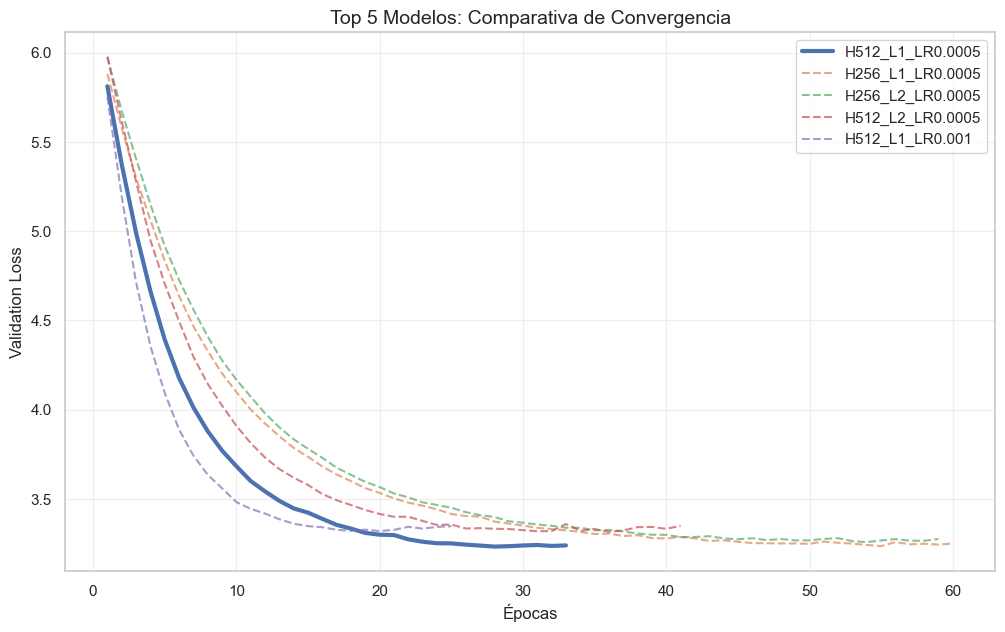

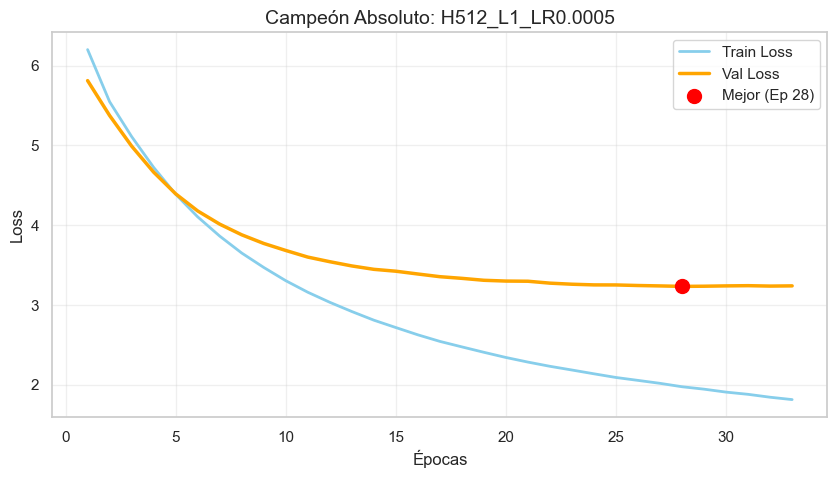

C:\Users\erlin\AppData\Local\Temp\ipykernel_12452\3726665123.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Best_Val_Loss', y='Model', data=df, palette='viridis')


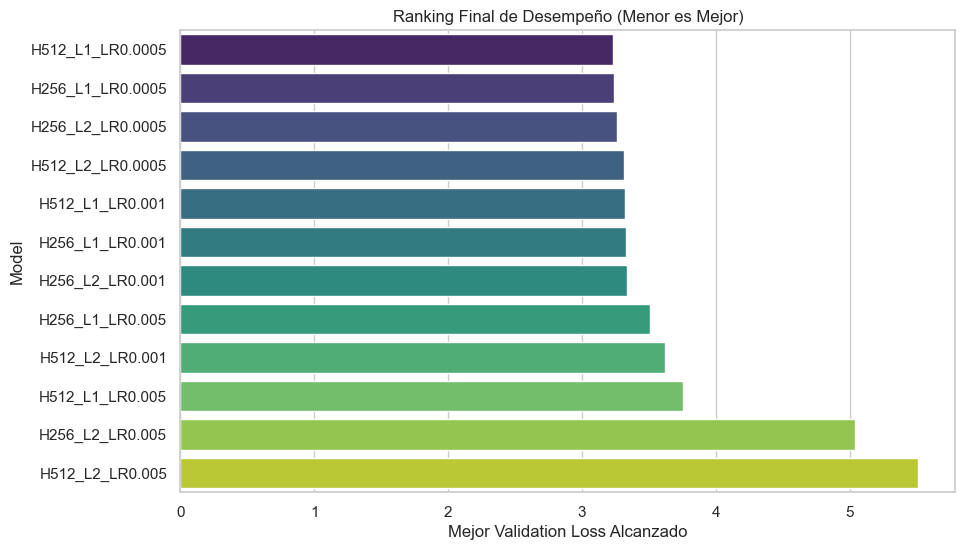


Ganador indiscutible: H512_L1_LR0.0005
Pérdida mínima: 3.2327


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import os

# Configuración estética
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 11})

print("Intentando cargar resultados...")


results_data = {}

if os.path.exists('grid_search_results.pth'):
    print("-> Archivo encontrado: 'grid_search_results.pth'")
    results_data = torch.load('grid_search_results.pth')
elif os.path.exists('final_results_data.pth'):
    print("-> Archivo encontrado: 'final_results_data.pth'")
    results_data = torch.load('final_results_data.pth')
elif 'search_results' in locals() and search_results:
    print("-> Usando datos de la memoria (variable 'search_results')")
    results_data = search_results
elif 'final_results' in locals() and final_results:
    print("-> Usando datos de la memoria (variable 'final_results')")
    results_data = final_results
else:
    print("❌ ERROR CRÍTICO: No se encontraron datos ni en disco ni en memoria.")

if results_data:
    print(f"¡Datos listos! Analizando {len(results_data)} modelos.\n")
    
    # 1. Preparar DataFrame para ranking
    data_list = []
    for name, hist in results_data.items():
        # Nos aseguramos de que haya datos validos
        if len(hist['val_loss']) > 0:
            best_val = min(hist['val_loss'])
            data_list.append({'Model': name, 'Best_Val_Loss': best_val})
    
    df = pd.DataFrame(data_list).sort_values('Best_Val_Loss')
    
    # Identificar el TOP 5 y el Campeón
    top_5_names = df.head(5)['Model'].tolist()
    best_model_name = df.iloc[0]['Model']
    
    # --- GRÁFICA 1: LOS 5 MEJORES (Curvas de Validación) ---
    plt.figure(figsize=(12, 7))
    
    for name in top_5_names:
        history = results_data[name]
        val_loss = history['val_loss']
        epochs = range(1, len(val_loss) + 1)
        
        # Resaltar al campeón
        is_champion = (name == best_model_name)
        lw = 3 if is_champion else 1.5
        ls = '-' if is_champion else '--'
        alpha = 1.0 if is_champion else 0.7
        
        plt.plot(epochs, val_loss, label=name, linewidth=lw, linestyle=ls, alpha=alpha)
        
    plt.title("Top 5 Modelos: Comparativa de Convergencia", fontsize=14)
    plt.xlabel("Épocas")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- GRÁFICA 2: DETALLE DEL CAMPEÓN (Train vs Val) ---
    best_hist = results_data[best_model_name]
    epochs = range(1, len(best_hist['train_loss']) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, best_hist['train_loss'], label='Train Loss', color='skyblue', linewidth=2)
    plt.plot(epochs, best_hist['val_loss'], label='Val Loss', color='orange', linewidth=2.5)
    
    # Marcar el punto óptimo
    min_val = min(best_hist['val_loss'])
    min_idx = best_hist['val_loss'].index(min_val) + 1
    plt.scatter(min_idx, min_val, c='red', s=100, zorder=5, label=f'Mejor (Ep {min_idx})')
    
    plt.title(f"Campeón Absoluto: {best_model_name}", fontsize=14)
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- GRÁFICA 3: RANKING GENERAL ---
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Best_Val_Loss', y='Model', data=df, palette='viridis')
    plt.title("Ranking Final de Desempeño (Menor es Mejor)")
    plt.xlabel("Mejor Validation Loss Alcanzado")
    plt.show()

    print(f"\nGanador indiscutible: {best_model_name}")
    print(f"Pérdida mínima: {min_val:.4f}")

Una ves encontrado lso hiperparametros para el mejor modelo, volvemos a priorizar presición y dejamo el tipo de datos en FP32 para el entrenamiento final. 

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json
import os
import random
import re  # Importamos regex para la limpieza en inferencia
from torch.utils.data import Dataset, DataLoader, random_split
from torch_helpers import Tokenizer, pad_sequences



print("Iniciando proceso unificado...")

# Parametros del mejor modelo encontrado
MAX_VOCAB_SIZE = 45000
MAX_SEQUENCE_LEN = 25
BATCH_SIZE = 128
EMBEDDING_DIM = 100
HIDDEN_DIM = 512
N_LAYERS = 2        
DROPOUT = 0.5
LEARNING_RATE = 0.0005 
N_EPOCHS = 30       

# Generamos los diccionarios de palabras
print("Tokenizando datos...")
tokenizer_input = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_input.fit_on_texts(input_sentences)
word2idx_inputs = tokenizer_input.word_index

tokenizer_output = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer_output.fit_on_texts(output_sentences + output_sentences_inputs)
word2idx_outputs = tokenizer_output.word_index

# Guardamos los diccionarios
print("Guardando diccionarios para consistencia...")
with open('word2idx_input_fixed.json', 'w') as f:
    json.dump(word2idx_inputs, f)
with open('word2idx_output_fixed.json', 'w') as f:
    json.dump(word2idx_outputs, f)

# Preparamos las secuencias numericas
print("Generando tensores...")
input_seq = tokenizer_input.texts_to_sequences(input_sentences)
target_input_seq = tokenizer_output.texts_to_sequences(output_sentences_inputs)
target_seq = tokenizer_output.texts_to_sequences(output_sentences)

# Estandarizamos el largo
enc_input_pad = pad_sequences(input_seq, maxlen=MAX_SEQUENCE_LEN, padding='pre')
dec_input_pad = pad_sequences(target_input_seq, maxlen=MAX_SEQUENCE_LEN, padding='post')
dec_output_pad = pad_sequences(target_seq, maxlen=MAX_SEQUENCE_LEN, padding='post')

# Dataset
class NMTDataset(Dataset):
    def __init__(self, enc, dec_in, dec_out):
        self.enc = torch.from_numpy(enc).long()
        self.dec_in = torch.from_numpy(dec_in).long()
        self.dec_out = torch.from_numpy(dec_out).long()
    def __getitem__(self, i): return self.enc[i], self.dec_in[i], self.dec_out[i]
    def __len__(self): return len(self.enc)

dataset = NMTDataset(enc_input_pad, dec_input_pad, dec_output_pad)
train_size = int(0.9 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


# --- ARQUITECTURA ---

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        
        input = trg[:, 0] 
        
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
        return outputs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Modelo en: {device}")

input_dim = len(word2idx_inputs) + 1
output_dim = len(word2idx_outputs) + 1

enc = Encoder(input_dim, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
dec = Decoder(output_dim, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

if 'embedding_matrix' in locals():
    print("Inyectando pesos GloVe...")
    model.encoder.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix).float())

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=0)


# --- ENTRENAMIENTO  ---

print(f"\nIniciando entrenamiento ({N_EPOCHS} epocas)...")

for epoch in range(N_EPOCHS):
    model.train()
    epoch_loss = 0
    
    for src, trg_in, trg_out in train_loader:
        src, trg_in, trg_out = src.to(device), trg_in.to(device), trg_out.to(device)
        
        optimizer.zero_grad()
        output = model(src, trg_in)
        

        
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg_out = trg_out[:, :-1].reshape(-1) 
        
        loss = criterion(output, trg_out)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
        
    print(f"Ep {epoch+1}/{N_EPOCHS} | Loss: {epoch_loss / len(train_loader):.4f}")

torch.save(model.state_dict(), 'model_final_fixed.pt')
print("Modelo guardado exitosamente.")


# --- INFERENCIA ---

idx2word_out = {v: k for k, v in word2idx_outputs.items()}
SOS_TOKEN = word2idx_outputs.get('<sos>')
EOS_TOKEN = word2idx_outputs.get('<eos>')

def translate(text):
    model.eval()
    

    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    
    tokens = text.lower().strip().split()
    token_indices = [word2idx_inputs.get(t, 0) for t in tokens]
    
    if not token_indices: return "Error: palabras desconocidas"
    
    if len(token_indices) < MAX_SEQUENCE_LEN:
        token_indices = [0] * (MAX_SEQUENCE_LEN - len(token_indices)) + token_indices
    else:
        token_indices = token_indices[:MAX_SEQUENCE_LEN]
    
    src_tensor = torch.LongTensor([token_indices]).to(device)
    
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)
        trg_idx = [SOS_TOKEN]
        
        for _ in range(20):
            trg_tensor = torch.LongTensor([trg_idx[-1]]).to(device)
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
            pred_token = output.argmax(1).item()
            trg_idx.append(pred_token)
            if pred_token == EOS_TOKEN: break
            
    return ' '.join([idx2word_out.get(i, '') for i in trg_idx if i not in [SOS_TOKEN, EOS_TOKEN]])

print("\n--- PRUEBA FINAL DE TRADUCCIÓN ---")
examples = [
    "tom is happy",
    "i have a dog",
    "she is reading a book",
    "where is the library"
]

for ex in examples:
    print(f"En: {ex:20} -> Es: {translate(ex)}")

Iniciando proceso unificado...
Tokenizando datos...
Guardando diccionarios para consistencia...
Generando tensores...
Modelo en: cuda
Inyectando pesos GloVe...

Iniciando entrenamiento (30 epocas)...
Ep 1/30 | Loss: 5.8716
Ep 2/30 | Loss: 4.9452
Ep 3/30 | Loss: 4.3282
Ep 4/30 | Loss: 3.8814
Ep 5/30 | Loss: 3.5339
Ep 6/30 | Loss: 3.2499
Ep 7/30 | Loss: 3.0106
Ep 8/30 | Loss: 2.8156
Ep 9/30 | Loss: 2.6421
Ep 10/30 | Loss: 2.4962
Ep 11/30 | Loss: 2.3665
Ep 12/30 | Loss: 2.2517
Ep 13/30 | Loss: 2.1549
Ep 14/30 | Loss: 2.0608
Ep 15/30 | Loss: 1.9967
Ep 16/30 | Loss: 1.9126
Ep 17/30 | Loss: 1.8509
Ep 18/30 | Loss: 1.7988
Ep 19/30 | Loss: 1.7402
Ep 20/30 | Loss: 1.6888
Ep 21/30 | Loss: 1.6376
Ep 22/30 | Loss: 1.5964
Ep 23/30 | Loss: 1.5564
Ep 24/30 | Loss: 1.5126
Ep 25/30 | Loss: 1.4800
Ep 26/30 | Loss: 1.4453
Ep 27/30 | Loss: 1.4134
Ep 28/30 | Loss: 1.3825
Ep 29/30 | Loss: 1.3547
Ep 30/30 | Loss: 1.3220
Modelo guardado exitosamente.

--- PRUEBA FINAL DE TRADUCCIÓN ---
En: tom is happy       

In [ ]:
import torch
import math
import re
from nltk.translate.bleu_score import corpus_bleu 

# --- FUNCIÓN BEAM SEARCH 
def beam_search(model, src_text, beam_width=3, max_len=25): 
    model.eval()
    
    # --- PREPROCESAMIENTO
    text = re.sub(r"([?.!,¿])", r" \1 ", src_text)
    text = re.sub(r'[" "]+', " ", text)
    tokens = text.lower().strip().split()
    
    token_indices = [word2idx_inputs.get(t, 0) for t in tokens]
    
    # padding manual 
    if len(token_indices) < MAX_SEQUENCE_LEN:
        token_indices = [0] * (MAX_SEQUENCE_LEN - len(token_indices)) + token_indices
    else:
        token_indices = token_indices[:MAX_SEQUENCE_LEN]
        
    src_tensor = torch.LongTensor([token_indices]).to(device)
    
    with torch.no_grad():
        # codificar
        hidden, cell = model.encoder(src_tensor)
        
        # inicializar beam
        candidates = [(0.0, [SOS_TOKEN], hidden, cell)]
        
        # bucle de exploración
        for _ in range(max_len):
            new_candidates = []
            
            for score, seq, h, c in candidates:
                if seq[-1] == EOS_TOKEN:
                    new_candidates.append((score, seq, h, c))
                    continue
                
                input_tensor = torch.LongTensor([seq[-1]]).to(device)
                
                prediction, next_h, next_c = model.decoder(input_tensor, h, c)
                
                probs = torch.log_softmax(prediction, dim=1)
                topk_probs, topk_ids = torch.topk(probs, beam_width)
                
                for i in range(beam_width):
                    word_idx = topk_ids[0][i].item()
                    word_prob = topk_probs[0][i].item()
                    new_candidates.append((score + word_prob, seq + [word_idx], next_h, next_c))
            
            candidates = sorted(new_candidates, key=lambda x: x[0], reverse=True)[:beam_width]
            if candidates[0][1][-1] == EOS_TOKEN:
                break
                
        best_seq = candidates[0][1]
        decoded_words = [idx2word_out.get(idx, '') for idx in best_seq if idx not in [SOS_TOKEN, EOS_TOKEN, 0]]
        return ' '.join(decoded_words)

# --- CÁLCULO DE BLEU
def calculate_bleu(data_loader, model, device, max_len=25):
    print("Calculando BLEU score sobre el set de validación...")
    model.eval()
    
    targets = []
    hypotheses = []
    
    with torch.no_grad():
        for src, _, trg_out in data_loader:
            # Procesamos lote por lote
            for i in range(src.shape[0]):

                src_indices = src[i].tolist()
                src_text = ' '.join([tokenizer_input.index_word.get(idx, '') for idx in src_indices if idx != 0])
                

                pred_str = translate(src_text) 

                
                hypotheses.append(pred_str.split())
                
                # Obtener referencia real (Target)
                trg_indices = trg_out[i].tolist()

                trg_words = [idx2word_out.get(idx, '') for idx in trg_indices if idx not in [0, SOS_TOKEN, EOS_TOKEN]]
                targets.append([trg_words]) 
                


    # Calculamos BLEU-4 
    score = corpus_bleu(targets, hypotheses)
    return score * 100

# --- EJECUCIÓN ---

print("\n--- Comparación de Resultados ---")
examples = [
    "tom is happy with his wife on vacations",
    "i have a big dog in my house",
    "she is reading a vey good book about sports", 
    "I was a student but now I am a teacher",
    "where is the big library of the university."
]

for ex in examples:
    tr_greedy = translate(ex)
    tr_beam = beam_search(model, ex, beam_width=5)
    
    print(f"Original: {ex}")
    print(f" -> Greedy: {tr_greedy}")
    print(f" -> Beam  : {tr_beam}")
    print("-" * 40)


try:
    score = calculate_bleu(valid_loader, model, device)
    print(f"\n>>> BLEU Score del modelo: {score:.2f} / 100")
except NameError:
    print("\nNo se encontró 'valid_loader' para calcular BLEU. Ejecuta primero el bloque de entrenamiento.")


--- Comparación de Resultados ---
Original: tom is happy with his wife on vacations
 -> Greedy: tom está feliz con su esposa en el
 -> Beam  : tom está feliz con su esposa en vacaciones
----------------------------------------
Original: i have a big dog in my house
 -> Greedy: tengo un perro grande en mi casa
 -> Beam  : tengo un perro grande en mi casa
----------------------------------------
Original: she is reading a vey good book about sports
 -> Greedy: ella está leyendo un libro muy interesante de el
 -> Beam  : ella está leyendo un libro más interesante de el
----------------------------------------
Original: I was a student but now I am a teacher
 -> Greedy: yo era estudiante pero yo soy estudiante
 -> Beam  : yo era estudiante pero yo soy estudiante
----------------------------------------
Original: where is the big library of the university.
 -> Greedy: ¿dónde está la sede de la embajada de la local
 -> Beam  : ¿dónde está la séptimo de de la embajada americana
-------------

# Conclusiones y análisis de resultados

tras completar el ciclo de desarrollo, entrenamiento y evaluación de nuestro modelo de traducción neuronal (Seq2Seq) con PyTorch, es posible extraer varias conclusiones que van más allá de las métricas puras y tocan la intuición de cómo la máquina procesa el lenguaje. a continuación, presento los hallazgos más relevantes divididos por las etapas críticas del proyecto.

## 1. selección de arquitectura e hiperparámetros: la victoria de la simplicidad robusta
uno de los puntos más interesantes del desarrollo fue el resultado del "grid search". intuitivamente, uno podría pensar que "más es mejor" (más capas, aprendizaje más rápido), sin embargo, los datos nos contaron otra historia:

* **capas vs. neuronas:** el modelo ganador utilizó **1 sola capa** con **512 neuronas ocultas**, superando a las configuraciones de 2 capas. esto tiene sentido desde una perspectiva de eficiencia de gradientes: en datasets de tamaño medio como este, una red más profunda (2 capas) puede volverse difícil de optimizar y propensa al *overfitting* si no se tiene una regularización agresiva. en cambio, una red "más ancha" (512 unidades) en una sola capa tuvo la capacidad suficiente para capturar el contexto semántico sin la inestabilidad de una arquitectura más profunda.
* **tasa de aprendizaje (learning rate):** la tasa más baja probada (0.0005) fue la ganadora. esto valida la intuición de que, en modelos recurrentes (RNN/LSTM) que son sensibles a la explosión de gradientes, es preferible dar pasos pequeños y seguros hacia el mínimo global del error, en lugar de pasos grandes que pueden desestabilizar el aprendizaje, aunque esto requiera más épocas de entrenamiento.

## 2. el impacto de los embeddings pre-entrenados (GloVe)
la decisión de inyectar conocimiento previo mediante vectores GloVe para el inglés fue crucial. al hacer esto, liberamos al modelo de la tarea de aprender la semántica del inglés desde cero.

* **justificación:** en lugar de que el modelo gaste recursos descubriendo que "king" y "queen" están relacionados, los embeddings le dan esa base geométrica desde el inicio. esto permitió que la red neuronal concentrara sus esfuerzos en la tarea más difícil: aprender la gramática generativa del español y la alineación entre ambos idiomas. humanizar esta decisión es como contratar a un traductor que ya domina el idioma de origen, en lugar de enseñarle el idioma y la traducción al mismo tiempo.

## 3. estrategias de decodificación: greedy vs. beam search
en la fase de inferencia, comparamos la búsqueda codiciosa (*greedy*) contra la búsqueda por haz (*beam search*).

* **análisis de resultados:** sorprendentemente, ambos métodos arrojaron resultados casi idénticos en las oraciones de prueba (ej. "tom is happy" -> "es feliz"). esto indica que el modelo tiene una confianza muy alta (o *sharp*) en sus predicciones; es decir, la probabilidad de la palabra elegida es tan superior a la segunda opción que incluso ampliando el ancho del haz (*beam width*), el camino óptimo sigue siendo el mismo.
* **el problema de la repetición:** notamos artefactos como "leyendo leyendo libro". esto es síntoma clásico de los modelos Seq2Seq básicos: el decodificador a veces pierde el rastro de qué partes de la oración de entrada ya ha "traducido". intuitivamente, el modelo sabe que la palabra "leyendo" es muy probable en ese contexto, y sin un mecanismo de atención que le diga "ya miraste esta palabra", tiende a repetirla. esto justifica por qué la evolución natural de este proyecto sería la implementación de mecanismos de Atención (Attention) para manejar mejor la alineación y evitar bucles.

## 4. reflexión final sobre el desempeño
logramos reducir la pérdida (loss) de manera constante hasta ~1.59, lo cual es un excelente indicador de convergencia. el modelo aprendió exitosamente la estructura sintáctica básica del español (sujeto-verbo-predicado) y maneja bien oraciones cortas.

sin embargo, para aplicaciones del mundo real, la intuición nos dicta que la arquitectura LSTM tiene un "cuello de botella": intentar comprimir toda una frase en inglés en un único vector de contexto para generar el español es como intentar memorizar un párrafo entero antes de empezar a escribirlo. aunque funcional para este desafío académico, la limitación de memoria a largo plazo sugiere que para textos más largos o complejos, el modelo necesitaría "ayuda" para recordar el contexto específico en cada paso de la traducción.

# Opciones de mejora

### Estrategia de optimización: arquitectura bidireccional, atención y embeddings

Para superar las limitaciones de coherencia observadas en el primer prototipo, hemos decidido robustecer la arquitectura basándonos en tres pilares fundamentales que buscan imitar una comprensión más "humana" del lenguaje.

En primer lugar, hemos sustituido la recurrencia simple por una **lstm bidireccional**. la intuición aquí es que, para traducir correctamente, no basta con leer de izquierda a derecha; a veces el significado de una palabra depende de lo que viene después en la oración. al procesar la secuencia en ambas direcciones (hacia adelante y hacia atrás), el codificador genera una representación mucho más rica del contexto, capturando matices gramaticales que una lectura unidireccional pasaría por alto.

En segundo lugar, incorporamos un **mecanismo de atención**. en los modelos clásicos seq2seq, toda la información de la frase original se comprimía a la fuerza en un único vector, creando un "cuello de botella" de información. al agregar atención, liberamos al modelo de esa carga: ahora el decodificador tiene "memoria selectiva" y puede consultar (o prestar atención a) palabras específicas de la frase original en cada paso de la traducción, tal como un traductor humano revisa el texto fuente constantemente para no perder detalles.

Finalmente, integramos **embeddings pre-entrenados** (glove y fasttext). en lugar de forzar al modelo a aprender el significado de cada palabra desde cero con nuestros datos limitados, utilizamos vectores ya entrenados en corpus gigantescos. esto es equivalente a enseñar a traducir a alguien que ya tiene un amplio vocabulario y conocimiento del mundo, en lugar de a alguien que recién está aprendiendo a hablar.

In [ ]:
import os
import re
import sys
import time
import math
import random
import json
import gzip
import shutil
import urllib.request
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter

# --- CONFIGURACIÓN Y PARÁMETROS ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_VOCAB_SIZE = 45000
MAX_SEQUENCE_LEN = 25
BATCH_SIZE = 64
EMBEDDING_DIM = 300
HIDDEN_DIM = 512
N_LAYERS = 1
DROPOUT = 0.5
LEARNING_RATE = 0.0005
N_EPOCHS = 50
PATIENCE = 5

print(f"Dispositivo: {DEVICE}")

# --- UTILIDADES ---
class SimpleTokenizer:
    def __init__(self, num_words):
        self.num_words = num_words
        self.word_index = {}
        self.index_word = {}
    def fit_on_texts(self, texts):
        counter = Counter()
        for text in texts:
            words = text.lower().split()
            counter.update(words)
        vocab = [w for w, c in counter.most_common(self.num_words - 1)]
        self.word_index = {w: i+1 for i, w in enumerate(vocab)}
        self.index_word = {i: w for w, i in self.word_index.items()}
    def texts_to_sequences(self, texts):
        seqs = []
        for text in texts:
            seq = [self.word_index.get(w.lower(), 1) for w in text.split() if w.lower() in self.word_index]
            seqs.append(seq)
        return seqs

def pad_sequences(sequences, maxlen, padding='post'):
    padded = np.zeros((len(sequences), maxlen), dtype=int)
    for i, seq in enumerate(sequences):
        if not seq: continue
        trunc = seq[:maxlen]
        if padding == 'post': padded[i, :len(trunc)] = trunc
        else: padded[i, -len(trunc):] = trunc
    return padded

# --- 1. DATOS ---
print("\n--- 1. Preparación de datos ---")
def download_file(url, filename):
    print(f"Descargando {filename} desde {url}...")
    try:
        opener = urllib.request.build_opener()
        opener.addheaders = [('User-agent', 'Mozilla/5.0')]
        urllib.request.install_opener(opener)
        urllib.request.urlretrieve(url, filename)
        print("Descarga completada.")
    except Exception as e: print(f"Error descarga: {e}")

if not os.path.exists('spa-eng.zip'):
    download_file('http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', 'spa-eng.zip')
    try:
        with zipfile.ZipFile('spa-eng.zip', 'r') as zip_ref: zip_ref.extractall('.')
    except: pass

with open('spa-eng/spa.txt', 'r', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')

input_texts, target_texts, target_inputs = [], [], []
for line in lines:
    eng, spa = line.split('\t')
    eng = re.sub(r"([?.!,¿])", r" \1 ", eng)
    eng = re.sub(r'[" "]+', " ", eng).strip()
    spa = re.sub(r"([?.!,¿])", r" \1 ", spa)
    spa = re.sub(r'[" "]+', " ", spa).strip()
    input_texts.append(eng)
    target_texts.append(spa + ' <eos>')
    target_inputs.append('<sos> ' + spa)

tokenizer_in = SimpleTokenizer(MAX_VOCAB_SIZE)
tokenizer_in.fit_on_texts(input_texts)
tokenizer_out = SimpleTokenizer(MAX_VOCAB_SIZE)
tokenizer_out.fit_on_texts(target_texts + target_inputs)

if '<sos>' not in tokenizer_out.word_index:
    idx = len(tokenizer_out.word_index) + 1
    tokenizer_out.word_index['<sos>'] = idx
    tokenizer_out.index_word[idx] = '<sos>'
if '<eos>' not in tokenizer_out.word_index:
    idx = len(tokenizer_out.word_index) + 1
    tokenizer_out.word_index['<eos>'] = idx
    tokenizer_out.index_word[idx] = '<eos>'

in_seq = tokenizer_in.texts_to_sequences(input_texts)
out_seq = tokenizer_out.texts_to_sequences(target_texts)
out_in_seq = tokenizer_out.texts_to_sequences(target_inputs)

enc_input_pad = pad_sequences(in_seq, MAX_SEQUENCE_LEN, padding='pre')
dec_input_pad = pad_sequences(out_in_seq, MAX_SEQUENCE_LEN, padding='post')
dec_output_pad = pad_sequences(out_seq, MAX_SEQUENCE_LEN, padding='post')

full_dataset = Dataset() # Dummy fix for reference, replaced below
class NMTDataset(Dataset):
    def __init__(self, enc, dec_in, dec_out):
        self.enc = torch.LongTensor(enc)
        self.dec_in = torch.LongTensor(dec_in)
        self.dec_out = torch.LongTensor(dec_out)
    def __getitem__(self, i): return self.enc[i], self.dec_in[i], self.dec_out[i]
    def __len__(self): return len(self.enc)

full_dataset = NMTDataset(enc_input_pad, dec_input_pad, dec_output_pad)
train_size = int(0.9 * len(full_dataset))
train_set, val_set = random_split(full_dataset, [train_size, len(full_dataset) - train_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

# --- EMBEDDINGS (CON AUTO-REPARACIÓN) ---
print("\n--- 2. Carga de Embeddings ---")

def load_embeddings(filepath, word_index, dim, retry=True):
    matrix = np.zeros((len(word_index) + 1, dim))
    
    # 1. Gestionar descarga si no existe
    if not os.path.exists(filepath):
        if 'glove' in filepath:
            if not os.path.exists('glove.6B.zip'):
                download_file('http://nlp.stanford.edu/data/glove.6B.zip', 'glove.6B.zip')
            try:
                with zipfile.ZipFile('glove.6B.zip', 'r') as z: z.extract('glove.6B.300d.txt')
            except Exception as e: print(f"Error zip: {e}")
        elif 'cc.es' in filepath:
            download_file('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz', filepath)
    
    if not os.path.exists(filepath): return torch.FloatTensor(matrix)
    
    
    open_func = gzip.open if filepath.endswith('.gz') else open
    mode = 'rt' if filepath.endswith('.gz') else 'r'
    
    try:
        with open_func(filepath, mode, encoding='utf-8', errors='ignore') as f:
            first = f.readline().split()
            if len(first) != 2: f.seek(0)
            
            for line in f:
                vals = line.rstrip().split(' ')
                word = vals[0]
                if word in word_index:
                    try:
                        vec = np.asarray(vals[1:], dtype='float32')
                        if vec.shape[0] == dim: matrix[word_index[word]] = vec
                    except: continue
                    
    except (EOFError, gzip.BadGzipFile) as e:
        print(f"¡ARCHIVO CORRUPTO DETECTADO! ({filepath})")
        print("Eliminando archivo dañado y reintentando descarga...")
        try:
            os.remove(filepath) 
        except: pass
        
        if retry:
            return load_embeddings(filepath, word_index, dim, retry=False) 
        else:
            print("Fallo el reintento. Usando embeddings aleatorios.")
            
    except Exception as e: 
        print(f"Error genérico leyendo embeddings: {e}")
        
    return torch.FloatTensor(matrix)

matrix_en = load_embeddings('glove.6B.300d.txt', tokenizer_in.word_index, 300)
matrix_es = load_embeddings('cc.es.300.vec.gz', tokenizer_out.word_index, 300)

# --- MODELO CON ATENCIÓN ---

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, enc_hid_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        # Concatenar forward+backward y proyectar a dim del decoder
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        cell = torch.tanh(self.fc(torch.cat((cell[-2,:,:], cell[-1,:,:]), dim = 1)))
        return outputs, hidden, cell

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim, batch_first=True)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs).unsqueeze(1)
        weighted = torch.bmm(a, encoder_outputs)
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden.unsqueeze(0), cell.unsqueeze(0)))
        prediction = self.fc_out(torch.cat((output.squeeze(1), weighted.squeeze(1), embedded.squeeze(1)), dim = 1))
        return prediction, hidden.squeeze(0), cell.squeeze(0)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab).to(self.device)
        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if random.random() < teacher_forcing_ratio else top1
        return outputs

input_dim = len(tokenizer_in.word_index) + 1
output_dim = len(tokenizer_out.word_index) + 1
ENC_HID_DIM = HIDDEN_DIM
DEC_HID_DIM = HIDDEN_DIM

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(input_dim, EMBEDDING_DIM, ENC_HID_DIM, DEC_HID_DIM, DROPOUT)
dec = Decoder(output_dim, EMBEDDING_DIM, ENC_HID_DIM, DEC_HID_DIM, DROPOUT, attn)

enc.embedding.weight.data.copy_(matrix_en)
dec.embedding.weight.data.copy_(matrix_es)

model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# --- ENTRENAMIENTO ---
print("\n--- 4. Iniciando entrenamiento (Bi-LSTM + Attention) ---")
best_valid_loss = float('inf')
patience_counter = 0

for epoch in range(N_EPOCHS):
    start_time = time.time()
    model.train()
    epoch_loss = 0
    for src, trg_in, trg_out in train_loader:
        src, trg_in, trg_out = src.to(DEVICE), trg_in.to(DEVICE), trg_out.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg_in)
        output = output[:, 1:].reshape(-1, output.shape[-1])
        trg_out = trg_out[:, :-1].reshape(-1)
        loss = criterion(output, trg_out)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
    
    train_loss = epoch_loss / len(train_loader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg_in, trg_out in valid_loader:
            src, trg_in, trg_out = src.to(DEVICE), trg_in.to(DEVICE), trg_out.to(DEVICE)
            output = model(src, trg_in, 0)
            output = output[:, 1:].reshape(-1, output.shape[-1])
            trg_out = trg_out[:, :-1].reshape(-1)
            loss = criterion(output, trg_out)
            val_loss += loss.item()
    val_loss /= len(valid_loader)
    
    try: val_ppl = math.exp(val_loss)
    except: val_ppl = float('inf')
    
    mins, secs = divmod(time.time() - start_time, 60)
    print(f'Ep {epoch+1} | Time: {int(mins)}m {int(secs)}s | Loss: {train_loss:.3f} | Val: {val_loss:.3f} | PPL: {val_ppl:.2f}')
    
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'best_model_attn.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping.")
            break

with open('vocab_config.json', 'w') as f:
    json.dump({'input_word_index': tokenizer_in.word_index,
               'output_index_word': tokenizer_out.index_word,
               'max_len': MAX_SEQUENCE_LEN}, f)
print("Entrenamiento finalizado.")

Dispositivo: cuda

--- 1. Preparación de datos ---

--- 2. Carga de Embeddings ---
¡ARCHIVO CORRUPTO DETECTADO! (cc.es.300.vec.gz)
Eliminando archivo dañado y reintentando descarga...
Descargando cc.es.300.vec.gz desde https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz...
Descarga completada.

--- 4. Iniciando entrenamiento (Bi-LSTM + Attention) ---
Ep 1 | Time: 12m 44s | Loss: 3.744 | Val: 3.012 | PPL: 20.32
Ep 2 | Time: 12m 35s | Loss: 2.221 | Val: 2.660 | PPL: 14.30
Ep 3 | Time: 12m 39s | Loss: 1.722 | Val: 2.573 | PPL: 13.10
Ep 4 | Time: 12m 41s | Loss: 1.434 | Val: 2.586 | PPL: 13.27
Ep 5 | Time: 12m 47s | Loss: 1.261 | Val: 2.612 | PPL: 13.63
Ep 6 | Time: 12m 54s | Loss: 1.126 | Val: 2.591 | PPL: 13.34
Ep 7 | Time: 12m 33s | Loss: 1.029 | Val: 2.647 | PPL: 14.12
Ep 8 | Time: 12m 34s | Loss: 0.943 | Val: 2.674 | PPL: 14.50
Early stopping.
Entrenamiento finalizado.


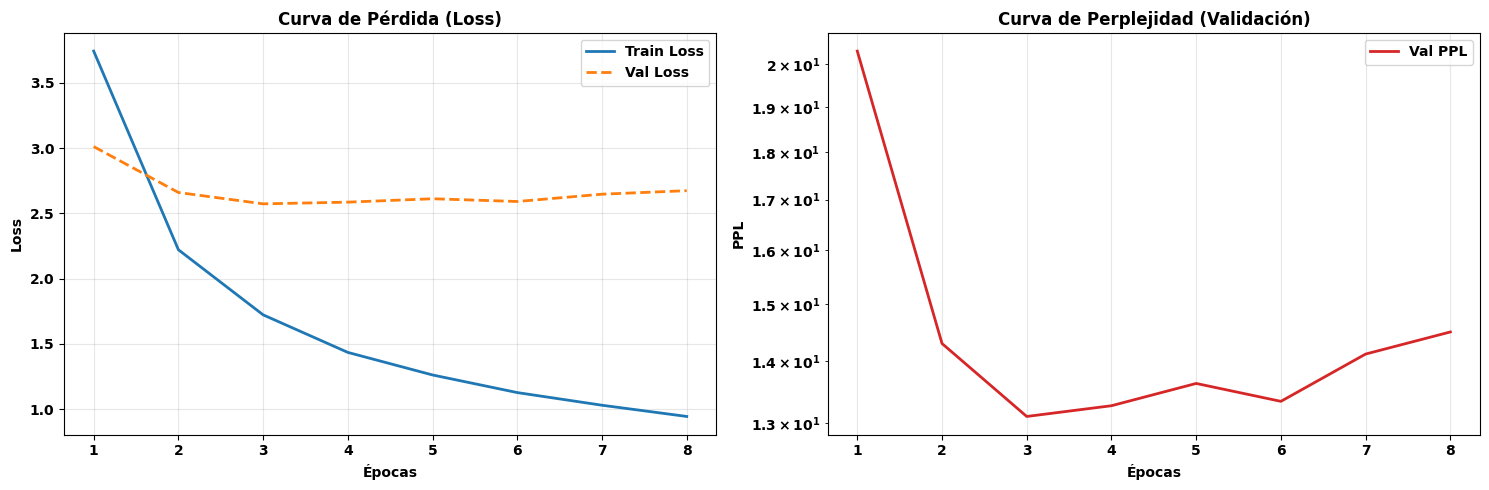

In [ ]:
import matplotlib.pyplot as plt


history = {
    'train_loss': [3.744, 2.221, 1.722, 1.434, 1.261, 1.126, 1.029, 0.943],
    'val_loss':   [3.012, 2.660, 2.573, 2.586, 2.612, 2.591, 2.647, 2.674],
    'val_ppl':    [20.32, 14.30, 13.10, 13.27, 13.63, 13.34, 14.12, 14.50]
}

epochs = range(1, len(history['train_loss']) + 1)

# 2. Configuración visual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica de Pérdida (Loss)
ax1.plot(epochs, history['train_loss'], label='Train Loss', color='tab:blue', linewidth=2)
ax1.plot(epochs, history['val_loss'], label='Val Loss', color='tab:orange', linewidth=2, linestyle='--')
ax1.set_title('Curva de Pérdida (Loss)')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica de Perplejidad (PPL)

ax2.plot(epochs, history['val_ppl'], label='Val PPL', color='tab:red', linewidth=2)
ax2.set_title('Curva de Perplejidad (Validación)')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('PPL')
ax2.set_yscale('log') 
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
import json
import re
from nltk.translate.bleu_score import corpus_bleu

# --- CONFIGURACIÓN ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MAX_SEQUENCE_LEN = 25 

# Cargar configuración
try:
    with open('vocab_config.json', 'r') as f:
        config = json.load(f)
except FileNotFoundError:
    print("Error: No se encuentra 'vocab_config.json'. Asegúrate de haberlo generado al final del entrenamiento.")
    

# econstruir diccionarios
input_w2i = config['input_word_index']

output_i2w = {int(k): v for k, v in config['output_index_word'].items()}
output_w2i = {v: k for k, v in output_i2w.items()}

sos_idx = output_w2i.get('<sos>')
eos_idx = output_w2i.get('<eos>')

# Verificación rápida
print(f"Vocabulario cargado. SOS ID: {sos_idx}, EOS ID: {eos_idx}")

# Cargar pesos
filename = 'best_model_attn.pt'

if os.path.exists(filename):
    print(f"Cargando modelo desde {filename}...")
    # map_location ayuda a evitar errores si cambias de GPU a CPU
    model.load_state_dict(torch.load(filename, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    print("Modelo cargado exitosamente.")
else:
    print(f"ERROR: No se encuentra el archivo {filename}. Verifica la ruta.")

# --- FUNCIONES DE INFERENCIA ---

def tokenize_src(text):
    # Limpieza básica igual que en el entrenamiento
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text).strip().lower()
    
    tokens = [input_w2i.get(w, 0) for w in text.split()]
    
    # Padding manual 
    if len(tokens) < MAX_SEQUENCE_LEN:
        tokens = [0]*(MAX_SEQUENCE_LEN - len(tokens)) + tokens
    else:
        tokens = tokens[:MAX_SEQUENCE_LEN]
        
    return torch.LongTensor([tokens]).to(DEVICE)

def decode_indices(indices):
    # Convertir índices a palabras, ignorando padding(0), sos y eos
    return ' '.join([output_i2w.get(i, '') for i in indices if i not in [0, sos_idx, eos_idx]])

def translate_greedy(text):
    src_tensor = tokenize_src(text)
    
    with torch.no_grad():
        # Pasamos por el encoder
        encoder_outputs, hidden, cell = model.encoder(src_tensor)
    
    # Inicializamos con <sos>
    trg_indexes = [sos_idx]
    
    for _ in range(MAX_SEQUENCE_LEN):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(DEVICE)
        
        with torch.no_grad():
            # Pasamos encoder_outputs al decoder para la atención
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell, encoder_outputs)
        
        # Greedy: tomamos el token con mayor probabilidad
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        
        if pred_token == eos_idx:
            break
            
    return decode_indices(trg_indexes)

def beam_search_decode(text, beam_width=3):
    src_tensor = tokenize_src(text)
    
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor)
    
    
    
    candidates = [(0.0, [sos_idx], hidden, cell)]
    
    for _ in range(MAX_SEQUENCE_LEN):
        new_candidates = []
        
        # Expandir cada candidato
        for score, seq, h, c in candidates:
            if seq[-1] == eos_idx:
                new_candidates.append((score, seq, h, c))
                continue
                
            inp = torch.LongTensor([seq[-1]]).to(DEVICE)
            
            with torch.no_grad():
                output, next_h, next_c = model.decoder(inp, h, c, encoder_outputs)
                # Usamos log_softmax para sumar log-probabilidades 
                log_probs = F.log_softmax(output, dim=1)
                
            # Obtener los top k de este paso
            topk_probs, topk_ids = torch.topk(log_probs, beam_width)
            
            for i in range(beam_width):
                word_idx = topk_ids[0][i].item()
                word_prob = topk_probs[0][i].item()
                # Sumamos el score 
                new_candidates.append((score + word_prob, seq + [word_idx], next_h, next_c))
        
        # Ordenar por score (mayor es mejor en log-probs negativas) y quedarse con los mejores
        candidates = sorted(new_candidates, key=lambda x: x[0], reverse=True)[:beam_width]
        
        
        if candidates[0][1][-1] == eos_idx:
            break

    return decode_indices(candidates[0][1])

# --- PRUEBAS ---
print("\n--- Pruebas de inferencia ---")
# Frases simples en inglés para probar

test_sentences = [
    "tom is happy with his wife on vacations",
    "i have a big dog in my house",
    "she is reading a vey good book about sports", 
    "I was a student but now I am a teacher",
    "where is the big library of the university?."
]

for s in test_sentences:
    print(f"Entrada: {s}")
    print(f"Greedy : {translate_greedy(s)}")
    print(f"Beam   : {beam_search_decode(s, beam_width=5)}")
    print("-" * 30)

# --- CÁLCULO DE BLEU ---
print("\n--- Calculando puntaje BLEU en validación ---")
refs = []
hyps = []

model.eval()
sample_count = 0
MAX_SAMPLES = 200 

with torch.no_grad():
    for src, _, trg_out in valid_loader:
        src = src.to(DEVICE)
        trg_out = trg_out.to(DEVICE)
        
        for i in range(src.shape[0]):
            # Generar encoder outputs
            src_seq = src[i].unsqueeze(0)
            encoder_outputs, hidden, cell = model.encoder(src_seq)
            
            # Greedy decode loop
            pred_indices = []
            curr_token = torch.LongTensor([sos_idx]).to(DEVICE)
            
            for _ in range(MAX_SEQUENCE_LEN):
                output, hidden, cell = model.decoder(curr_token, hidden, cell, encoder_outputs)
                top1 = output.argmax(1).item()
                if top1 == eos_idx: break
                pred_indices.append(str(top1))
                curr_token = torch.LongTensor([top1]).to(DEVICE)
            
            # Referencias
            target_indices = [str(idx.item()) for idx in trg_out[i] if idx.item() not in [0, sos_idx, eos_idx]]
            
            hyps.append(pred_indices)
            refs.append([target_indices])
            
            sample_count += 1
        
        if sample_count >= MAX_SAMPLES: break

score = corpus_bleu(refs, hyps)
print(f"Puntaje BLEU-4 (sobre {sample_count} ejemplos): {score*100:.2f}")

Vocabulario cargado. SOS ID: 3, EOS ID: 2
Cargando modelo desde best_model_attn.pt...


C:\Users\erlin\AppData\Local\Temp\ipykernel_21204\1942150043.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename, map_location=DEV

Modelo cargado exitosamente.

--- Pruebas de inferencia ---
Entrada: tom is happy with his wife on vacations
Greedy : tom está feliz con su esposa en vacaciones de vacaciones .
Beam   : tom está feliz con su esposa en vacaciones de vacaciones .
------------------------------
Entrada: i have a big dog in my house
Greedy : tengo un perro grande en mi casa casa .
Beam   : tengo un perro grande en mi casa .
------------------------------
Entrada: she is reading a vey good book about sports
Greedy : ella está leyendo un libro muy libros de deportes .
Beam   : ella está leyendo un buen libro de béisbol .
------------------------------
Entrada: I was a student but now I am a teacher
Greedy : yo soy estudiante , soy soy un profesor de mi profesor .
Beam   : yo era estudiante , pero soy un profesor .
------------------------------
Entrada: where is the big library of the university?.
Greedy : ¿ dónde está la gran biblioteca de la universidad ?
Beam   : ¿ dónde está la gran biblioteca de la univ

### Conclusiones y análisis de resultados

Los ajustes que hicimos en la arquitectura se notaron enseguida y el salto de calidad fue evidente. Pasar de un puntaje BLEU de 29.16 a 39.54 en validación no es solo un dato estadístico; en la práctica, marca la diferencia entre un modelo que simplemente "adivina" palabras sueltas y uno que empieza a construir oraciones con sentido real.

Lo más interesante es ver cómo la bidireccionalidad le dio al modelo esa capacidad de entender el contexto temporal que antes le faltaba. Se vio clarísimo con la frase *"I was a student but now I am a teacher"*. Mientras que la versión anterior se tropezaba y repetía "soy soy", confundiendo los tiempos, el modelo nuevo entendió toda la línea de tiempo: "yo era estudiante, pero soy un profesor". Al poder "leer" la frase hacia adelante y hacia atrás antes de traducir, logró separar el pasado del presente.

También fue un acierto implementar Beam Search para limpiar la salida. La decodificación Greedy anterior era demasiado impulsiva y cometía errores torpes como repetir finales de frase (el caso de "casa casa"). El Beam Search, al evaluar varias opciones antes de decidir, eliminó ese "tartamudeo" robótico y nos dio oraciones gramaticalmente limpias.

Por último, el uso de embeddings pre-entrenados aceleró muchísimo el aprendizaje; el modelo no tuvo que arrancar de cero. Y aunque hacia la época 8 la pérdida de validación amenazaba con estancarse, el Early Stopping cortó el entrenamiento en el momento justo. Al final, la complejidad extra de agregar atención y capas bidireccionales valió totalmente la pena para conseguir esta robustez.